In [81]:
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tqdm


In [ ]:
df = pd.read_csv("data/state_of_the_data_dataset.csv")

df.head()

,0.a_token,0.d_data/hora_envio,1.a_idade,1.a.1_faixa_idade,1.b_genero,1.c_cor/raca/etnia,1.d_pcd,1.e_experiencia_profissional_prejudicada,1.e.1_Não acredito que minha experiência profissional seja afetada,"1.e.2_Sim, devido a minha Cor/Raça/Etnia",...,"8.d.3_Entrando em contato com os times de negócio para definição do problema, identificar a solução e apresentação de resultados.",8.d.4_Desenvolvendo modelos de Machine Learning com o objetivo de colocar em produção em sistemas (produtos de dados).,"8.d.5_Colocando modelos em produção, criando os pipelines de dados, APIs de consumo e monitoramento.","8.d.6_Cuidando da manutenção de modelos de Machine Learning já em produção, atuando no monitoramento, ajustes e refatoração quando necessário.","8.d.7_Realizando construções de dashboards em ferramentas de BI como PowerBI, Tableau, Looker, Qlik, etc.","8.d.8_Utilizando ferramentas avançadas de estatística como SAS, SPSS, Stata etc, para realizar análises.","8.d.9_Criando e dando manutenção em ETLs, DAGs e automações de pipelines de dados.",8.d.10_Criando e gerenciando soluções de Feature Store e cultura de MLOps.,"8.d.11_Criando e mantendo a infra que meus modelos e soluções rodam (clusters, servidores, API, containers, etc.)",8.d.12_Treinando e aplicando LLM's para solucionar problemas de negócio.
0,reb94rv0msth7q4nreb94riaq80iz3yi,16/10/2024 11:19:17,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1zc66g69jjt49y32l1zc66g8wqj79m4e,16/10/2024 20:45:31,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,uu99wmam4n5kc2uu99wmydf0rk7l58f7,17/10/2024 18:10:59,18,17-21,Masculino,Parda,Não,Não acredito que minha experiência profissiona...,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3ynsw7z0hl5hhpbfvaeqk73ynsw7z04l,22/10/2024 18:03:00,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,v6bji2ct5xckpl1uouv6bjiotkrf3b4f,23/10/2024 01:33:23,18,17-21,Masculino,Branca,Não,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Definimos **nove quasi-identificadores**. São eles:

In [86]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '1.b_genero',
    '2.i_tempo_de_experiencia_em_dados',
    '2.j_tempo_de_experiencia_em_ti',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    '2.f_cargo_atual',
    '2.b_setor',
    '2.c_numero_de_funcionarios'
]

for col in quasi_identifiers:
    print(df[col].unique())
    print("\n")

['RS' 'SC' 'SP' 'DF' 'MA' 'BA' 'MG' 'PR' 'MT' 'GO' 'AL' 'PB' 'PE' 'RJ'
 'ES' 'AP' 'CE' 'TO' 'PI' 'MS' 'RN' 'AM' nan 'RO' 'SE' 'PA']


['Masculino' 'Feminino' 'Outro' 'Prefiro não informar']


['de 1 a 2 anos' 'Menos de 1 ano' 'Não tenho experiência na área de dados'
 nan 'de 5 a 6 anos' 'de 3 a 4 anos' 'de 7 a 10 anos' 'Mais de 10 anos']


['de 1 a 2 anos' 'Menos de 1 ano'
 'Não tive experiência na área de TI/Engenharia de Software antes de começar a trabalhar na área de dados'
 nan 'de 3 a 4 anos' 'de 5 a 6 anos' 'de 7 a 10 anos' 'Mais de 10 anos']


['Estudante de Graduação' 'Graduação/Bacharelado'
 'Não tenho graduação formal' 'Prefiro não informar' 'Pós-graduação'
 'Doutorado ou Phd' 'Mestrado']


['Computação / Engenharia de Software / Sistemas de Informação/ TI'
 'Economia/ Administração / Contabilidade / Finanças/ Negócios' nan
 'Estatística/ Matemática / Matemática Computacional/ Ciências Atuariais'
 'Outra opção'
 'Outras Engenharias (não incluir engenharia de software ou TI)'

Esses atributos foram escolhidos porque podem ser extraídos com alto grau de precisão a partir de um scraping de perfis no LinkedIn. Assim, representam atributos de alto risco para reidentificação.

## Premissa Geral

Estamos considerando que **é razoável assumir que os perfis do LinkedIn coletados correspondem a indivíduos presentes no dataset *State-of-the-Data***. Essa suposição se fundamenta no fato de que os perfis foram extraídos a partir de interações (como curtidas) em posts de divulgação da própria pesquisa — posts que explicitamente convidavam profissionais da área de dados a respondê-la.

Embora não seja possível garantir com certeza absoluta que todos esses indivíduos efetivamente participaram da pesquisa, essa hipótese é razoável o suficiente para fins de análise. Com base nela, adotamos o seguinte raciocínio:

> **Se existe uma classe de equivalência de tamanho 1 formada por um conjunto de quasi-identificadores que também estão presentes no perfil de um indivíduo do LinkedIn, então é razoável assumir que sabemos quem é aquela pessoa no dataset.**


## Perguntas a serem respondidas

> **Esses nove quasi-identificadores são suficientes para identificar unicamente indivíduos do dataset?**

Para isso, vamos agrupar os registros utilizando os nove quasi-identificadores e observar a distribuição do tamanho das classes de equivalência. Se houver muitas classes com tamanho 1, isso indica uma alta capacidade de reidentificação — o que compromete o anonimato.
* **É necessário usar todos os nove?**
* **Qual o menor subconjunto que já gera pelo menos uma classe de equivalência de tamanho 1?**
* **Como varia o risco de reidentificação conforme aumentamos o número de quasi-identificadores utilizados?**



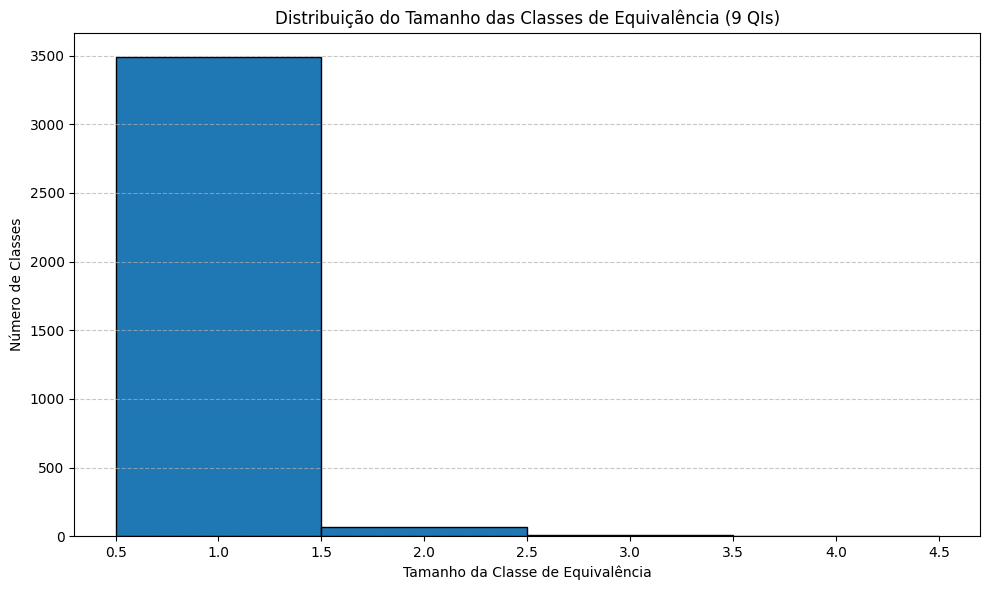

Número de classes de equivalência com tamanho 1: 3492
Número de classes de equivalência com tamanho 2: 70
Número de classes de equivalência com tamanho 3: 8
Total de classes de equivalência: 3571


In [87]:
grupos = df.groupby(quasi_identifiers).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.hist(grupos['count'], bins=range(1, grupos['count'].max() + 2), edgecolor='black', align='left')
plt.title('Distribuição do Tamanho das Classes de Equivalência (9 QIs)')
plt.xlabel('Tamanho da Classe de Equivalência')
plt.ylabel('Número de Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

num_grupos_tam_1 = (grupos['count'] == 1).sum()
num_grupos_tam_2 = (grupos['count'] == 2).sum()
num_grupos_tam_3 = (grupos['count'] == 3).sum()
total_grupos = len(grupos)
print(f'Número de classes de equivalência com tamanho 1: {num_grupos_tam_1}')
print(f'Número de classes de equivalência com tamanho 2: {num_grupos_tam_2}')
print(f'Número de classes de equivalência com tamanho 3: {num_grupos_tam_3}')
print(f'Total de classes de equivalência: {total_grupos}')


Ao utilizar os oito quasi-identificadores, obtemos 3.492 classes de equivalência com tamanho 1, em um total de 5.217 registros. Ademais, tempos apenas 70 classes de equivalência de tamanho 2 e 8 de tamanho 3. Isso é um forte indício de que esses identificadores, em conjunto, são suficientes para possibilitar a reidentificação de indivíduos.

No entanto, dois dos atributos utilizados — tempo de experiência em dados e tempo de experiência em TI — não são completamente confiáveis a partir de perfis do LinkedIn, pois dependem da forma como a pessoa descreve sua trajetória profissional e podem estar sujeitos a omissões ou interpretações diferentes.

Diante disso, surge a próxima pergunta:

> Se retirarmos esses dois campos, ainda assim conseguimos formar classes de equivalência com tamanho 1?

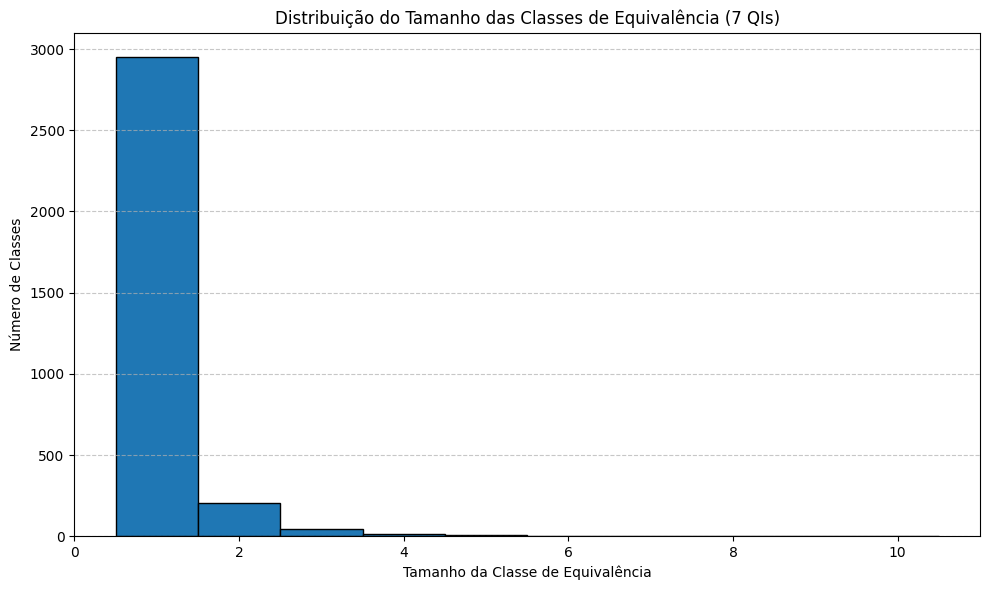

Número de classes de equivalência com tamanho 1: 2952
Número de classes de equivalência com tamanho 2: 204
Número de classes de equivalência com tamanho 3: 47
Total de classes de equivalência: 3232


In [88]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '1.b_genero',
    # '2.i_tempo_de_experiencia_em_dados',
    # '2.j_tempo_de_experiencia_em_ti',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    '2.f_cargo_atual',
    '2.b_setor',
    '2.c_numero_de_funcionarios'
]

grupos = df.groupby(quasi_identifiers).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.hist(grupos['count'], bins=range(1, grupos['count'].max() + 2), edgecolor='black', align='left')
plt.title('Distribuição do Tamanho das Classes de Equivalência (7 QIs)')
plt.xlabel('Tamanho da Classe de Equivalência')
plt.ylabel('Número de Classes')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

num_grupos_tam_1 = (grupos['count'] == 1).sum()
num_grupos_tam_2 = (grupos['count'] == 2).sum()
num_grupos_tam_3 = (grupos['count'] == 3).sum()
total_grupos = len(grupos)
print(f'Número de classes de equivalência com tamanho 1: {num_grupos_tam_1}')
print(f'Número de classes de equivalência com tamanho 2: {num_grupos_tam_2}')
print(f'Número de classes de equivalência com tamanho 3: {num_grupos_tam_3}')
print(f'Total de classes de equivalência: {total_grupos}')

Ao remover os dois quasi-identificadores (`tempo de experiência em dados` e `tempo de experiência em TI`), ainda assim observamos um risco relevante de reidentificação:

* **2.952 classes de equivalência têm tamanho 1**, ou seja, 2.270 indivíduos ainda podem ser identificados unicamente.
* Outras **204 classes têm tamanho 2**, o que significa que, ao observar alguém com essas características no LinkedIn, temos **50% de chance** de acertar qual indivíduo é aquele no dataset.

Portanto, mesmo **sem os dois atributos menos confiáveis**, a estrutura do dataset já permite um grau preocupante de reidentificação. Com os oito quasi-identificadores, o potencial de identificar pessoas com precisão é ainda mais elevado.

In [89]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '2.f_cargo_atual',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    '2.i_tempo_de_experiencia_em_dados',
    '2.j_tempo_de_experiencia_em_ti',
    '1.b_genero',
    '2.b_setor',
    '2.c_numero_de_funcionarios',
]

def analisar_distribuicoes(df, quasi_identifiers):
    estatisticas = []

    for r in range(1, len(quasi_identifiers) + 1):
        for combinacao in itertools.combinations(quasi_identifiers, r):
            grupos = df.groupby(list(combinacao)).size()
            counts = grupos.value_counts().sort_index()

            total_grupos = len(grupos)
            grupos_tam_1 = (grupos == 1).sum()
            min_tam = grupos.min()
            max_tam = grupos.max()
            media_tam = grupos.mean()

            estatisticas.append({
                'num_qi': r,
                'combinacao': combinacao,
                'total_grupos': total_grupos,
                'grupos_tamanho_1': grupos_tam_1,
                'proporcao_tam_1': grupos_tam_1 / total_grupos,
                'min_tamanho': min_tam,
                'max_tamanho': max_tam,
                'media_tamanho': media_tam
            })

    return pd.DataFrame(estatisticas)

estatisticas_df = analisar_distribuicoes(df, quasi_identifiers)


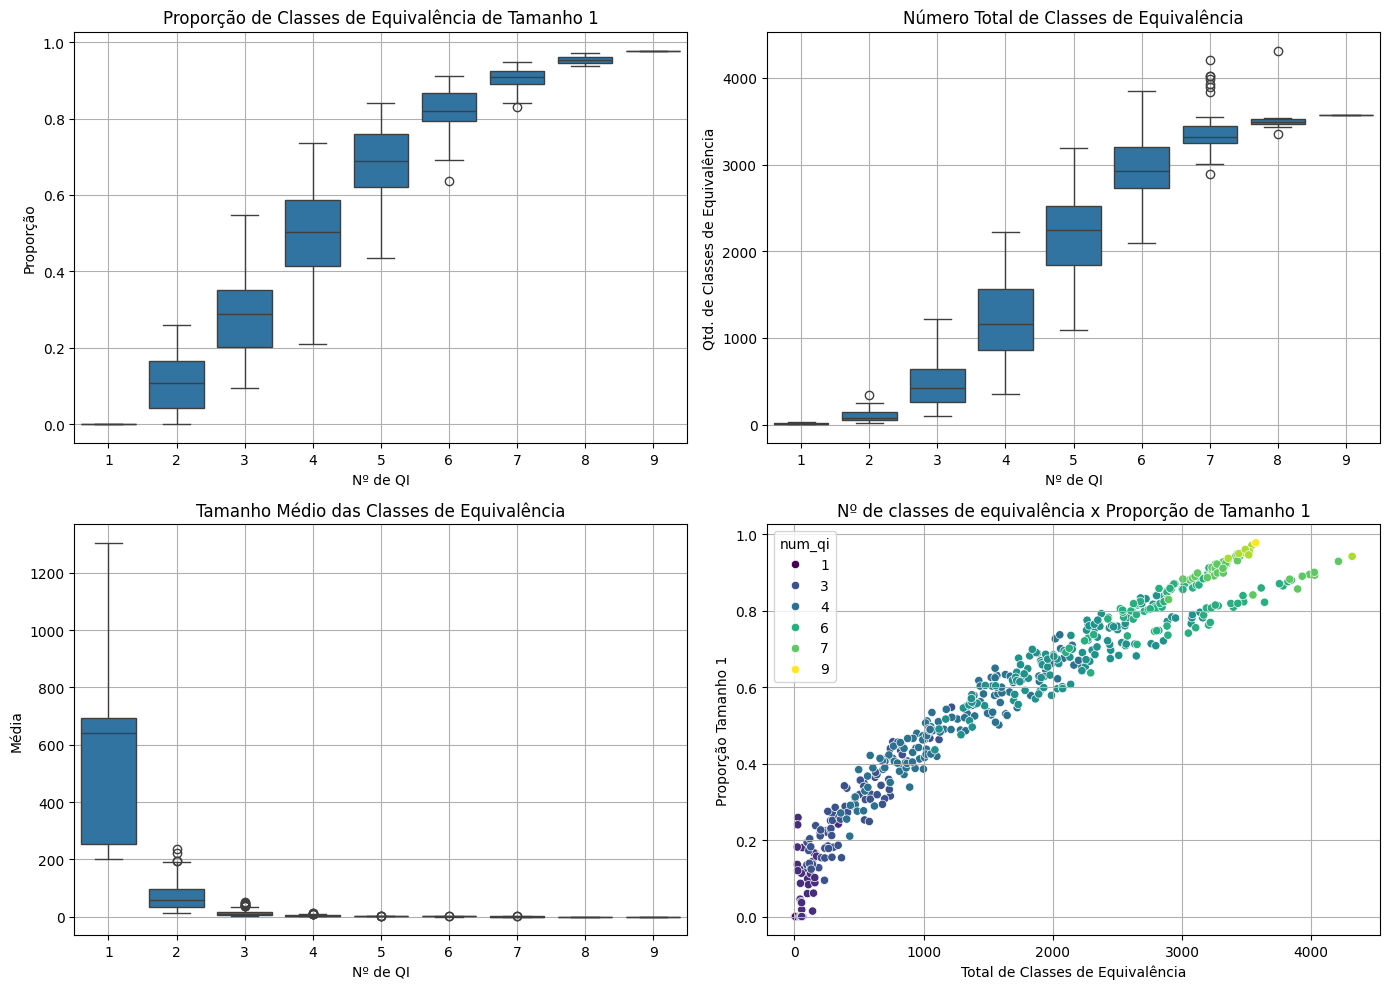

In [90]:
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='num_qi', y='proporcao_tam_1', data=estatisticas_df)
plt.title('Proporção de Classes de Equivalência de Tamanho 1')
plt.xlabel('Nº de QI')
plt.ylabel('Proporção')
plt.grid(True)

plt.subplot(2, 2, 2)
sns.boxplot(x='num_qi', y='total_grupos', data=estatisticas_df)
plt.title('Número Total de Classes de Equivalência')
plt.xlabel('Nº de QI')
plt.ylabel('Qtd. de Classes de Equivalência')
plt.grid(True)

plt.subplot(2, 2, 3)
sns.boxplot(x='num_qi', y='media_tamanho', data=estatisticas_df)
plt.title('Tamanho Médio das Classes de Equivalência')
plt.xlabel('Nº de QI')
plt.ylabel('Média')
plt.grid(True)

plt.subplot(2, 2, 4)
sns.scatterplot(x='total_grupos', y='proporcao_tam_1', hue='num_qi', data=estatisticas_df, palette='viridis')
plt.title('Nº de classes de equivalência x Proporção de Tamanho 1')
plt.xlabel('Total de Classes de Equivalência')
plt.ylabel('Proporção Tamanho 1')
plt.grid(True)

plt.tight_layout()
plt.show()


In [91]:
linha_max = estatisticas_df.loc[estatisticas_df['proporcao_tam_1'].idxmax()]

print("Número de quasi-identificadores:", linha_max['num_qi'])
print("Combinação responsável:", linha_max['combinacao'])
print("Total de grupos (classes de equivalência):", linha_max['total_grupos'])
print("Grupos com tamanho 1:", linha_max['grupos_tamanho_1'])
print("Proporção de grupos com tamanho 1:", f"{linha_max['proporcao_tam_1']:.2%}")
print("Tamanho mínimo de grupo:", linha_max['min_tamanho'])
print("Tamanho máximo de grupo:", linha_max['max_tamanho'])
print("Tamanho médio dos grupos:", f"{linha_max['media_tamanho']:.2f}")

Número de quasi-identificadores: 9
Combinação responsável: ('1.i.1_uf_onde_mora', '2.f_cargo_atual', '1.l_nivel_de_ensino', '1.m_área_de_formação', '2.i_tempo_de_experiencia_em_dados', '2.j_tempo_de_experiencia_em_ti', '1.b_genero', '2.b_setor', '2.c_numero_de_funcionarios')
Total de grupos (classes de equivalência): 3571
Grupos com tamanho 1: 3492
Proporção de grupos com tamanho 1: 97.79%
Tamanho mínimo de grupo: 1
Tamanho máximo de grupo: 4
Tamanho médio dos grupos: 1.02


In [92]:
linha_max = estatisticas_df.loc[estatisticas_df['total_grupos'].idxmax()]

print("Número de quasi-identificadores:", linha_max['num_qi'])
print("Combinação responsável:", linha_max['combinacao'])
print("Total de grupos (classes de equivalência):", linha_max['total_grupos'])
print("Grupos com tamanho 1:", linha_max['grupos_tamanho_1'])
print("Proporção de grupos com tamanho 1:", f"{linha_max['proporcao_tam_1']:.2%}")
print("Tamanho mínimo de grupo:", linha_max['min_tamanho'])
print("Tamanho máximo de grupo:", linha_max['max_tamanho'])
print("Tamanho médio dos grupos:", f"{linha_max['media_tamanho']:.2f}")

Número de quasi-identificadores: 8
Combinação responsável: ('1.i.1_uf_onde_mora', '1.l_nivel_de_ensino', '1.m_área_de_formação', '2.i_tempo_de_experiencia_em_dados', '2.j_tempo_de_experiencia_em_ti', '1.b_genero', '2.b_setor', '2.c_numero_de_funcionarios')
Total de grupos (classes de equivalência): 4317
Grupos com tamanho 1: 4068
Proporção de grupos com tamanho 1: 94.23%
Tamanho mínimo de grupo: 1
Tamanho máximo de grupo: 6
Tamanho médio dos grupos: 1.08


1. **Identificabilidade elevada**:
   Ao usar os 9 quase-identificadores, mais de **97%** das classes de equivalência têm tamanho 1, evidenciando forte capacidade de reidentificação.

2. **Com 8 QIs ainda é elevado**:
   A partir de 6 quase-identificadores, a **proporção de grupos de tamanho 1 ultrapassa 94%**, indicando que **nem todos os QIs são necessários** para atingir esse grau de granularidade.

3. **Queda da média é esperada**:
   A média do tamanho dos grupos cai rapidamente — o que é esperado, já que a fragmentação cria muitos grupos de tamanho 1, e poucos grandes.

4. **Ponto ótimo (linha de dominância de Pareto)**:
   Há um ponto destacado no gráfico, que **usa apenas 7 QIs** (todos exceto `cargo_atual`), que tem **mais de 4.000 grupos únicos e alta proporção de tamanho 1**.
   Esse ponto está na **fronteira de Pareto** (não é dominado em nenhuma dimensão: nem em número de grupos nem em proporção).

## Desanonimização

Neste experimento, definimos um conjunto de **quasi-identificadores** — atributos não sensíveis que, em combinação, podem ser utilizados para inferir informações privadas — e um **atributo sensível**, que é a *faixa salarial*. 

O processo de desanonimização baseou-se na criação de **classes de equivalência**: grupos de registros que compartilham exatamente os mesmos valores de quasi-identifiers. Uma reidentificação foi considerada possível em dois casos:
- Quando a classe de equivalência possuía apenas **um único registro** (`k = 1`);
- Ou quando **todos os registros da classe** possuíam o **mesmo valor de atributo sensível**, o que nos permite inferi-lo com 100% de certeza.

In [ ]:
quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '2.i_tempo_de_experiencia_em_dados',
    '2.j_tempo_de_experiencia_em_ti',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    # '1.b_genero',
    # '2.b_setor',
    # '2.c_numero_de_funcionarios',
    '2.f_cargo_atual'
]

sensitive_attribute = '2.h_faixa_salarial'

df_anon = pd.read_csv("data/state_of_the_data_dataset.csv")
df_ident = pd.read_csv("data/linkedin_profiles_data.csv")

grupos_anon = df_anon.groupby(quasi_identifiers).size().reset_index(name='k_frequencia')
grupos_anon = grupos_anon.sort_values(by='k_frequencia', ascending=True).reset_index(drop=True)
grupos_anon['id_classe_equivalencia'] = range(1, len(grupos_anon) + 1)

colunas_reordenadas = ['id_classe_equivalencia', 'k_frequencia'] + [col for col in grupos_anon.columns if col not in ['id_classe_equivalencia', 'k_frequencia']]
grupos_anon = grupos_anon[colunas_reordenadas]

df_anon_com_id = df_anon.merge(grupos_anon, on=quasi_identifiers, how='left')
df_ident_com_id = df_ident.merge(grupos_anon, on=quasi_identifiers, how='left')

agrupamento_sensivel = df_anon_com_id.groupby('id_classe_equivalencia').agg(
    k_frequencia=('id_classe_equivalencia', 'count'),
    valores_sensiveis_unicos=(sensitive_attribute, pd.Series.nunique)
).reset_index()

classes_validas = agrupamento_sensivel[
    (agrupamento_sensivel['k_frequencia'] == 1) |
    (agrupamento_sensivel['valores_sensiveis_unicos'] == 1)
]['id_classe_equivalencia']

mapa_sensivel = (
    df_anon_com_id[df_anon_com_id['id_classe_equivalencia'].isin(classes_validas)]
    .groupby('id_classe_equivalencia')[sensitive_attribute]
    .first()
    .reset_index()
)

df_reidentificaveis = df_ident_com_id[df_ident_com_id['id_classe_equivalencia'].isin(classes_validas)]
df_reidentificaveis = df_reidentificaveis.merge(mapa_sensivel, on='id_classe_equivalencia', how='left')

colunas_resultado = (
    ['nome', 'link_perfil', sensitive_attribute, 'id_classe_equivalencia'] +
    quasi_identifiers
)

df_resultado = df_reidentificaveis[colunas_resultado].copy()
df_resultado = df_resultado.sort_values(by='id_classe_equivalencia').reset_index(drop=True)

df_resultado.to_csv("data/possiveis_reidentificacoes.csv", index=False)

Utilizando esses quasi-identificadores definidos, conseguimos **reidentificar 27 pessoas** do dataset. Ou seja, essas 27 entradas do conjunto identificado puderam ser ligadas ao dataset anonimizado com **certeza sobre sua faixa salarial**.

### Variação no número de quasi-identificadores

Para investigar como a quantidade de informação afeta o risco de desanonimização, passamos a **variar o número de quasi-identificadores utilizados**.

Para cada valor de `n` (de 1 até 9), geramos **todas as combinações possíveis** de `n` atributos e aplicamos o mesmo processo de reidentificação para cada combinação. O número de reidentificações foi computado e registrado.

Com isso, conseguimos observar como o aumento no número de atributos utilizados impacta diretamente a quantidade de registros passíveis de reidentificação.

In [ ]:
sensitive_attribute = '2.h_faixa_salarial'

df_anon = pd.read_csv("data/state_of_the_data_dataset.csv")
df_ident = pd.read_csv("data/linkedin_profiles_data.csv")

todos_quasi_identifiers = [
    '1.i.1_uf_onde_mora',
    '2.i_tempo_de_experiencia_em_dados',
    '2.j_tempo_de_experiencia_em_ti',
    '1.l_nivel_de_ensino',
    '1.m_área_de_formação',
    '1.b_genero',
    '2.b_setor',
    '2.c_numero_de_funcionarios',
    '2.f_cargo_atual'
]

resultados = []

for r in range(1, len(todos_quasi_identifiers) + 1):
    combinacoes = list(itertools.combinations(todos_quasi_identifiers, r))
    
    for qids in tqdm(combinacoes, desc=f"{r} QIDs"):
        grupos = df_anon.groupby(list(qids)).size().reset_index(name='k_frequencia')
        grupos['id_classe_equivalencia'] = range(1, len(grupos) + 1)

        df_anon_id = df_anon.merge(grupos, on=list(qids), how='left')
        df_ident_id = df_ident.merge(grupos, on=list(qids), how='left')

        agrupamento_sensivel = df_anon_id.groupby('id_classe_equivalencia').agg(
            k_frequencia=('id_classe_equivalencia', 'count'),
            valores_sensiveis_unicos=(sensitive_attribute, pd.Series.nunique)
        ).reset_index()

        classes_validas = agrupamento_sensivel[
            (agrupamento_sensivel['k_frequencia'] == 1) |
            (agrupamento_sensivel['valores_sensiveis_unicos'] == 1)
        ]['id_classe_equivalencia']

        df_ident_validos = df_ident_id[df_ident_id['id_classe_equivalencia'].isin(classes_validas)]

        resultados.append({
            'num_qids': r,
            'combinacao': qids,
            'num_reidentificacoes': len(df_ident_validos)
        })

df_resultados = pd.DataFrame(resultados)

df_resultados.to_csv("data/analise_reidentificacoes_por_qid.csv", index=False)


9 QIDs: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


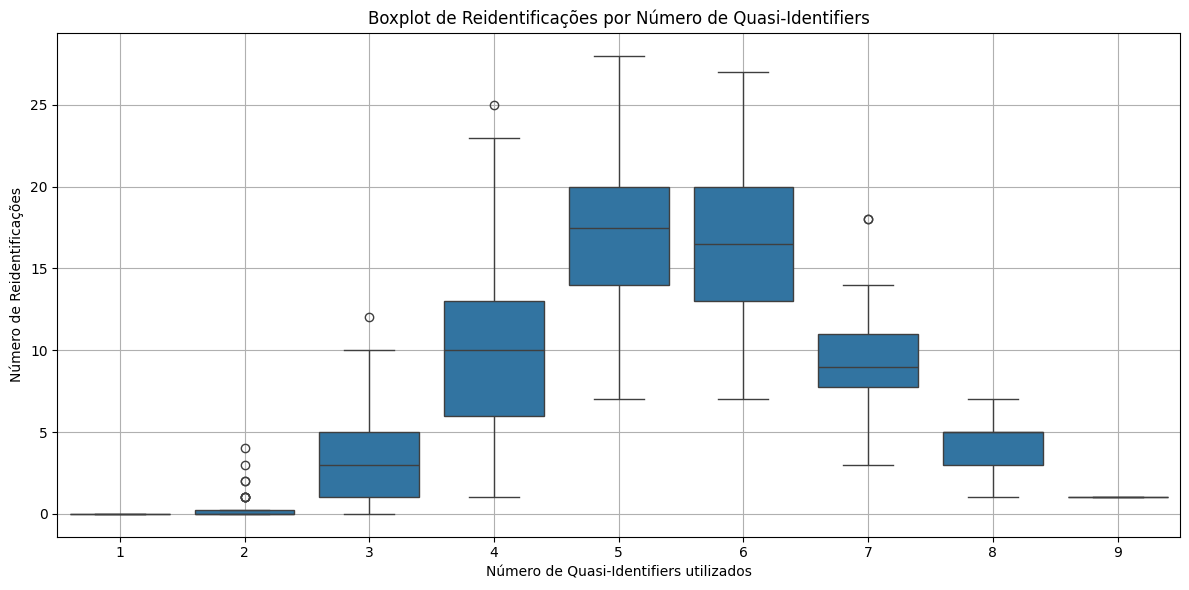

In [ ]:
df = pd.read_csv("data/analise_reidentificacoes_por_qid.csv")

plt.figure(figsize=(12, 6))
sns.boxplot(x="num_qids", y="num_reidentificacoes", data=df)
plt.title("Boxplot de Reidentificações por Número de Quasi-Identifiers")
plt.xlabel("Número de Quasi-Identifiers utilizados")
plt.ylabel("Número de Reidentificações")
plt.grid(True)
plt.tight_layout()
plt.show()


O gráfico gerado mostra o número de reidentificações em função do número de quasi-identificadores utilizados. Os principais achados:

- Com **apenas 1 quasi-identificador**, nenhuma reidentificação foi possível. Isso ocorre porque as **classes de equivalência são muito amplas** e, portanto, os valores sensíveis variam entre os registros.
- À medida que o número de quasi-identificadores aumenta, o **número de reidentificações cresce**, pois as classes se tornam mais específicas.
- No entanto, a partir de **5 ou 6 atributos**, começamos a observar uma **queda no número de reidentificações**, mesmo com mais informação teórica disponível.

Esse comportamento aparentemente paradoxal revela um **compromisso entre granularidade e qualidade dos dados**: quanto mais atributos usamos, maior a chance de divergência entre os dados dos dois conjuntos (ex: respostas da pesquisa vs inferências a partir do LinkedIn).

A queda nas reidentificações a partir de um certo ponto pode ser explicada pela **acumulação de incerteza**.

À medida que mais atributos são usados, aumentamos a chance de divergência entre os dados inferidos (ex: LinkedIn) e os dados fornecidos (ex: pesquisa). Exemplos comuns:
- O setor da empresa pode ter sido **classificado de forma diferente** entre as duas fontes;
- O número de funcionários pode estar **desatualizado no LinkedIn**, ou pode ter sido **interpretado de forma distinta**.

Ou seja, atributos adicionais não necessariamente contribuem com **informações confiáveis**. Ao contrário, podem **introduzir ruído** que impede o match entre registros.

Isso fica evidente no fato de que, usando todos os 9 quasi-identificadores, **apenas uma reidentificação** foi possível.